In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import networkx as nx

In [42]:
def Conexiones(anchura, altura):
    conexiones = {}
    for i in range(altura):
        for j in range(anchura):
            nodo = i * anchura + j
            vecinos = []
            
            if i % 2 == 0:

                if i > 0:
                    vecinos.append(nodo - anchura)

                    if j > 0:
                        vecinos.append(nodo - anchura - 1)

                if i < altura - 1:
                    vecinos.append(nodo + anchura)

                    if j > 0:
                        vecinos.append(nodo + anchura - 1)

            else:

                if i > 0:
                    vecinos.append(nodo - anchura)

                    if j < anchura - 1:
                        vecinos.append(nodo - anchura + 1)

                if i < altura - 1:
                    vecinos.append(nodo + anchura)
                    
                    if j < anchura - 1:
                        vecinos.append(nodo + anchura + 1)

            if j > 0:
                vecinos.append(nodo - 1)
            
            if j < anchura - 1:
                vecinos.append(nodo + 1)
            
            conexiones[nodo] = vecinos
    
    return conexiones

anchura = 25
altura = 25
numTPlantas = 10
conexiones = Conexiones(anchura, altura)


nodo = 25

competencia = {
    1: [1, 1, 2, 1, 0, 0, 0, 0, 1, 2],
    2: [1, 2, 2, 2, 0, 1, 1, 1, 2, 2],
    3: [2, 2, 1, 2, 0, 0, 0, 0, 2, 2],
    4: [1, 2, 2, 1, 1, 1, 1, 1, 2, 2],
    5: [0, 0, 0, 1, 1, 2, 2, 2, 1, 0],
    6: [0, 1, 0, 1, 2, 1, 2, 2, 1, 0],
    7: [0, 1, 0, 1, 2, 2, 1, 2, 1, 0],
    8: [0, 1, 0, 1, 2, 2, 2, 1, 1, 0],
    9: [1, 2, 2, 2, 1, 1, 1, 1, 1, 1],
    10: [2, 2, 2, 2, 2, 0, 0, 0, 1, 1]
}

maximos = [40, 185, 40, 40, 47, 36, 69, 61, 82, 25]
suma = sum(maximos)
probabilidad = [i/suma for i in maximos]

total_plantas = 625 # Total plantas
grid_prob = np.random.rand(25,25) # Dimensiones cuadrícula y llenar de probabilidades
grid_prob = np.where(grid_prob < 0.1, 1, 0) # 1 si es menor a 0.1, 0 lo contrario.

# Reemplazar los valores igual a 1 con números aleatorios entre 1 y 10
grid_prob[grid_prob == 1] = np.random.randint(1, 11, size=np.count_nonzero(grid_prob == 1))
Plantas_en_Lugar = int(np.sum(grid_prob == 0)) # Plantas ya declaradas como puestas
valores_existentes = []
for i in range(25):
    for j in range(25):
            valores_existentes.append(grid_prob[i][j])

from collections import Counter
a = dict(Counter(valores_existentes))

# Sumar los valores que son diferentes de 0
# Sumar todos los valores excepto el valor de la clave 0
sumaPlantasIniciales = sum(value for key, value in a.items() if key != 0)

In [43]:
# Función para obtener los hijos de la cruza de los dos padres
def Cruce(padre1: list[int], padre2: list[int]) -> list[list[int]]:
    hijo1 = padre1[:125] + padre2[125:250] + padre1[250:375] + padre2[375:500] + padre1[500:]
    hijo2 = padre2[:125] + padre1[125:250] + padre2[250:375] + padre1[375:500] + padre2[500:]
    hijo3 = padre2[:125] + padre2[125:250] + padre1[250:375] + padre1[375:500] + padre2[500:]
    hijo4 = padre1[:125] + padre1[125:250] + padre2[250:375] + padre2[375:500] + padre1[500:]
    hijo5 = padre2[:125] + padre1[125:250] + padre1[250:375] + padre2[375:500] + padre2[500:]
    hijo6 = padre1[:125] + padre2[125:250] + padre2[250:375] + padre1[375:500] + padre1[500:]
    hijo7 = padre2[:125] + padre2[125:250] + padre1[250:375] + padre2[375:500] + padre1[500:]
    hijo8 = padre1[:125] + padre1[125:250] + padre2[250:375] + padre1[375:500] + padre2[500:]
    
    return [hijo1, hijo2, hijo3, hijo4, hijo5, hijo6, hijo7, hijo8]

def Contar(cromosoma: list[int]) -> list[int]:
    valores = []
    for i in range(1,11):
        valores.append(cromosoma.count(i))
    return valores

def Penalizar(valores: list[int]) -> int:
    acumulado = 0
    diferencia = [maximos[i] - valores[i] for i in range(10)]
    for i in range(len(diferencia)):
        if diferencia[i] < 0:
            acumulado += diferencia[i]
    
    return acumulado

     

# Función para determinar el valor de la función fitness de una solución
def Fitness(cromosoma: list[int] ) -> float:
    penalizacion = 0
    for i in range(len(cromosoma)):
        planta1 = cromosoma[i]
        for j in conexiones.get(i, []):  
            planta2 = cromosoma[j]
            penalizacion += competencia[planta1][planta2-1]
    return (penalizacion + Penalizar(Contar(cromosoma))*25) /7104

# Función para mutar un cromosoma con una probabilidad del 5% por gen
def Mutacion(cromosomas: list[list[int]]) -> list[list[int]]:
    for i in range(len(cromosomas)):
        for j in range(len(cromosomas[i])):
            numeroRandom = random.random()
            if valores_existentes[j] == 0:
                if numeroRandom <= 0.05:
                    cromosomas[i][j] = random.choice(range(1,numTPlantas+1))
    return cromosomas

# Función para determinar los padres de la siguiente iteración usando el método de la ruleta
def Ruleta(poblacion: list[list[int]] ) -> tuple[list[int], list[int]]:
    padres = []
    fitnessPoblacion = [Fitness(i) for i in poblacion]
    suma = sum(fitnessPoblacion)
    fitnessPoblacion[0] = fitnessPoblacion[0]/suma
    for i in range(1,len(poblacion)):
        fitnessPoblacion[i] = fitnessPoblacion[i]/suma + fitnessPoblacion[i-1]
    for i in range(2):
        numeroRandom = random.random()
        for j in range(len(fitnessPoblacion)):
            if numeroRandom <= fitnessPoblacion[j]:
                padres.append(poblacion[j])
                break
    return padres[0], padres[1]

# Función para determinar si los hijos reemplazaran a algún individuo dentro de la población
def Reemplazo(Hijos: list[list[int]], poblacion: list[list[int]] ) -> list[list[int]]:
    copiaPoblacion = poblacion.copy()
    copiaPoblacion.sort(key = Fitness)
    for i in Hijos:
        if Fitness(i) > Fitness(copiaPoblacion[0]):
            copiaPoblacion.pop(0)
            copiaPoblacion.append(i)
    return copiaPoblacion

# Función para iniciar la población de forma aleatoria
def InicializarPoblacion(longitud: int) -> list[list[int]]:
    poblacion = []
    for _ in range(longitud):
        cromosoma = [np.random.choice(range(1, 11), p = probabilidad) for _ in range(625)]
        cromosoma = SimulacionPlantasExistentes(cromosoma)
        poblacion.append(cromosoma)
    return poblacion

def SimulacionPlantasExistentes(poblacion: list[int]) -> list[int]:
    for i in range(len(poblacion)):
        if valores_existentes[i] > 0:
            poblacion[i] = valores_existentes[i]
    return poblacion


In [44]:
inicio = time.time()
iteraciones = 6000
tamañoPoblacion = 30

poblacion = InicializarPoblacion(tamañoPoblacion)

for k in range(iteraciones):
    padre1, padre2 = Ruleta(poblacion)
    hijos = Cruce(padre1, padre2)
    hijosMutados = Mutacion(hijos)
    poblacion = Reemplazo(hijosMutados, poblacion) 

poblacion.sort(key = Fitness, reverse = True)
solucion = poblacion[0]
fin = time.time()
#colores = Colores(solucion)

plantasPorPlantar = []
plantasTotal = Contar(solucion)
for i in range (10):
    tmp = plantasTotal[i]
    plantas_existentes = sum(value for key, value in a.items() if key == i+1)
    plantasPorPlantar.append(tmp-plantas_existentes)

print(f'Solución: {solucion}')
print(f'Cantidad de plantas de cada tipo: {Contar(solucion)}')
print(f'Diferencia: {[maximos[i] - Contar(solucion)[i] for i in range(10)]}')
print(f'Fitness: {Fitness(solucion)}')
print(f'Tiempo de Ejecución: {fin-inicio}')
print(f"Plantas iniciales: {sumaPlantasIniciales}")
print(f'Plantas por plantar: {plantasPorPlantar}')

Solución: [np.int64(8), 9, np.int64(5), np.int64(7), 1, np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(8), np.int64(6), np.int64(1), np.int64(10), np.int64(7), np.int64(7), 6, np.int64(7), np.int64(10), np.int64(9), 7, 6, np.int64(6), np.int64(4), 9, np.int64(2), np.int64(7), np.int64(1), 2, 7, 3, np.int64(7), np.int64(2), np.int64(2), 9, 8, np.int64(7), 5, np.int64(9), np.int64(10), np.int64(2), 9, np.int64(2), np.int64(2), 9, 6, 2, np.int64(2), np.int64(3), 10, 1, 10, np.int64(7), np.int64(5), 8, np.int64(5), np.int64(2), 8, np.int64(5), np.int64(7), 2, 9, 6, np.int64(9), 4, np.int64(4), np.int64(2), 9, 2, 9, np.int64(10), np.int64(5), np.int64(7), 4, np.int64(2), 2, 3, np.int64(9), 4, np.int64(5), np.int64(2), 2, np.int64(4), 8, np.int64(9), np.int64(2), np.int64(2), np.int64(7), 3, np.int64(2), np.int64(8), 4, 1, np.int64(2), np.int64(2), np.int64(8), np.int64(2), 2, np.int64(2), 2, 6, np.int64(2), np.int64(2), np.int64(4), np.int64(2), np.int64(9), np.in

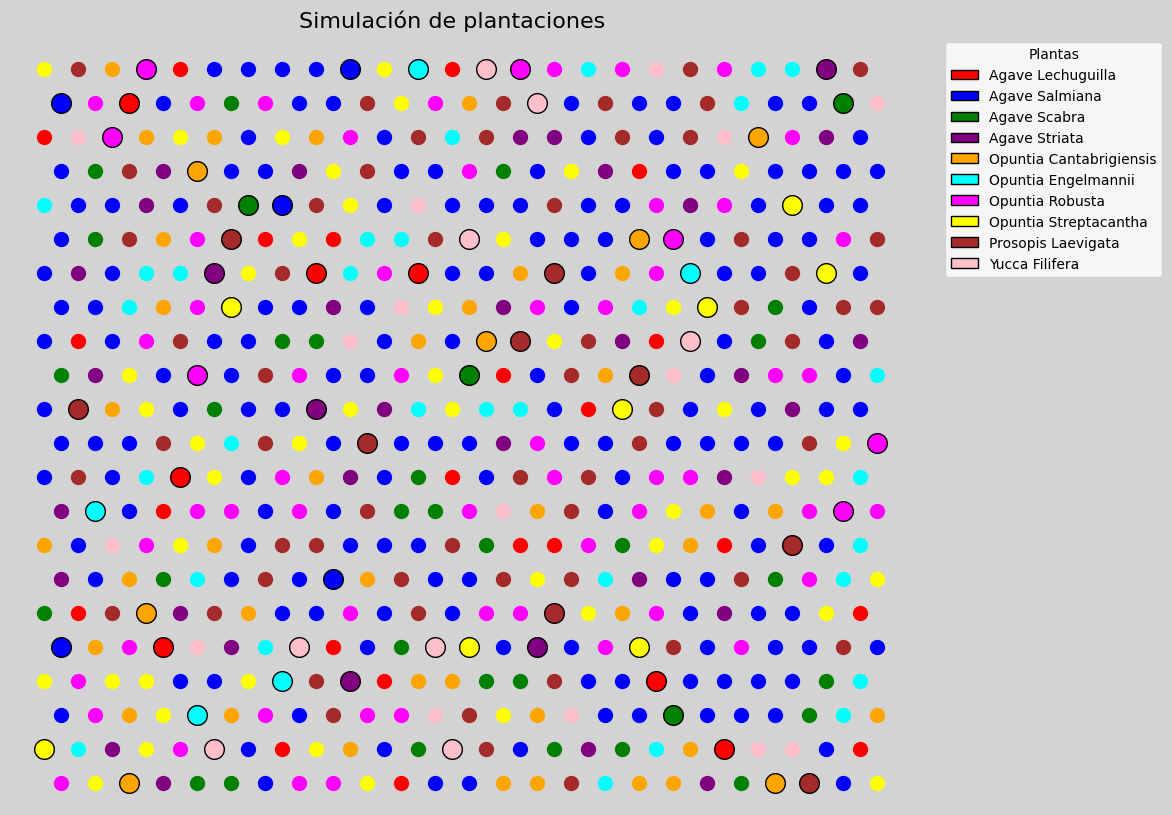

In [45]:
import matplotlib.patches as patches

colormap = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 
    5: 'orange', 6: 'cyan', 7: 'magenta', 8: 'yellow',
    9: 'brown', 10: 'pink'
}
labels = {
    1: 'Agave Lechuguilla', 
2:'Agave Salmiana', 
3:'Agave Scabra', 
4:'Agave Striata', 
5:'Opuntia Cantabrigiensis', 
6:'Opuntia Engelmannii', 
7:'Opuntia Robusta', 
8:'Opuntia Streptacantha', 
9:'Prosopis Laevigata', 
10:'Yucca Filifera'
}
# Parámetros
filas = 25
columnas = 25

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Establecer el color de fondo de la figura y los ejes
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('lightgray')


# Plotear los puntos
for i, value in enumerate(solucion):
    fila = i // 25
    columna = i % 25
    x = columna + (fila % 2) * 0.5
    y = fila
    color = colormap[value] if value > 0 else 'gray'
    if valores_existentes[i] > 0:
        ax.scatter(x, y, color=color, edgecolor='black', s=200)  # Con contorno blanco
    else:
        ax.scatter(x, y, color=color, s=100)  # Sin contorno

# Poner etiquetas
legend_elements = [patches.Patch(facecolor=color, edgecolor='black', label=labels[key]) 
                   for key, color in colormap.items()]
ax.legend(handles=legend_elements, title="Plantas", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Simulación de plantaciones", fontsize=16)

ax.set_xlim(-1, columnas)
ax.set_ylim(-1, filas * np.sqrt(3) / 2)
ax.set_aspect('equal')

# Invertir el eje y para que el origen esté en la esquina superior izquierda
ax.invert_yaxis()

# Ocultar ejes
ax.axis('off')

# Mostrar la gráfica
plt.show()